In [2]:
import os
import time
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
warnings.filterwarnings("ignore")

import allocation
import portfolio_summary
import utils as hrp_utils

In [3]:
import importlib
importlib.reload(allocation)
importlib.reload(hrp_utils)
importlib.reload(portfolio_summary)

<module 'portfolio_summary' from '/Users/vdp/projects/hierarchical_risk_parity/portfolio_summary.py'>

In [94]:
# directory information
CUR_DIR = os.getcwd()
DATA_FOLDER = os.path.join(CUR_DIR, "data")
ALL_DATA = os.path.join(DATA_FOLDER, "dataset.feather")

## Loading Data

#### NOTE: SNP Constituents are calculated at the start of the each year and remain the same for entire year

In [5]:
df = pd.read_feather(ALL_DATA)
df.head()

,date,ticker,permno,ret,mkt_cap,shrout,prc,year
0,2000-01-03,ROK,84381,0.031332,9392211.250,190222.0,49.3750,2000
1,2000-01-04,ROK,84381,-0.036709,9047433.875,190222.0,47.5625,2000
2,2000-01-05,ROK,84381,0.005256,9094989.375,190222.0,47.8125,2000
3,2000-01-06,ROK,84381,-0.016993,8940434.000,190222.0,47.0000,2000
4,2000-01-07,ROK,84381,0.027926,9190100.375,190222.0,48.3125,2000


#### Filtering for required data

In [95]:
data_df = df[["date", "permno", "ret", "year", "mkt_cap"]]
data_df.head()

,date,permno,ret,year,mkt_cap
0,2000-01-03,84381,0.031332,2000,9392211.250
1,2000-01-04,84381,-0.036709,2000,9047433.875
2,2000-01-05,84381,0.005256,2000,9094989.375
3,2000-01-06,84381,-0.016993,2000,8940434.000
4,2000-01-07,84381,0.027926,2000,9190100.375


#### Cleaning the dataset for each year

In [7]:
data_df = data_df.groupby("year").apply(lambda x: hrp_utils.clean_dataset(x)).reset_index(drop=True)
data_df.head()

,date,permno,ret,year,mkt_cap
0,2000-01-03,84381,0.031332,2000,9392211.250
1,2000-01-04,84381,-0.036709,2000,9047433.875
2,2000-01-05,84381,0.005256,2000,9094989.375
3,2000-01-06,84381,-0.016993,2000,8940434.000
4,2000-01-07,84381,0.027926,2000,9190100.375


### Bases Cases: 
    1. Market weighted returns
    2. Equal weighted returns

#### Market weights are calculated based on latest previous year (lagged) market cap for each stock

In [8]:
mkt_df = data_df.drop_duplicates(subset=["year", "permno"], keep="last")[["year", "permno", "mkt_cap"]].reset_index(drop=True)
mkt_df["lag_mkt_cap"] =  mkt_df.groupby(["permno"])["mkt_cap"].shift()
mkt_df = mkt_df.dropna().reset_index(drop=True)
mkt_df.head()

,year,permno,mkt_cap,lag_mkt_cap
0,2001,84381,3.285829e+06,8.701516e+06
1,2001,81061,1.069640e+07,1.019093e+07
2,2001,85914,1.570485e+07,6.112195e+06
3,2001,21207,3.748044e+06,2.869930e+06
4,2001,87800,2.240735e+06,1.603648e+07


#### Using compute functions form allocation library to get market and equal weights

In [9]:
mkt_wgt_df = mkt_df.groupby("year").apply(lambda x: allocation.compute_mkt_weights(x)).reset_index()
eq_wgt_df = mkt_df.groupby("year").apply(lambda x: allocation.compute_unif_weights(x)).reset_index()

#### Calculating daily returns for the market weighted and equal weighted portfolio starting 2001

In [10]:
base_df = data_df.merge(mkt_wgt_df, on=["year", "permno"], how="left")
base_df = base_df[base_df["year"] > 2000]

base_df = base_df.merge(eq_wgt_df, on=["year", "permno"], how="left")
base_df["MKT_ret"] = base_df["ret"] * base_df["MKT"]
base_df["EQ_ret"] = base_df["ret"] * base_df["EQ"]

# daily returns of the portfolio
base_ret_df = base_df.groupby("date")["MKT_ret", "EQ_ret"].sum()
base_ret_df

,MKT_ret,EQ_ret
date,,
2001-01-02,-0.028877,-0.028219
2001-01-03,0.055665,0.046295
2001-01-04,-0.012854,-0.009114
2001-01-05,-0.025212,-0.020683
2001-01-08,-0.001344,0.002724
...,...,...
2022-12-23,0.004794,0.006778
2022-12-27,-0.007404,0.000080
2022-12-28,-0.011456,-0.013615


## HRP Performance with Different Linkages

In [11]:
linkage_types = ["single", "complete", "ward", "average"]

### Splitting dataset by year, getting weights based on previous year correlations, measuring weighted returns for current year 

In [12]:
%%time
test_df_lst = list()

for year in range(2001, 2023):
    test_df = data_df[data_df["year"] == year].set_index("permno")
    stocks = test_df.index
    
    form_df = data_df[data_df["year"] == (year - 1)]
    form_df = form_df[form_df["permno"].isin(stocks)]
    
    weights_list = list()
    for linkage_type in linkage_types:
        weight_df = allocation.compute_hrp_weights(df=form_df, linkage_type=linkage_type).to_frame()
        test_df = test_df.join(weight_df)
        
        wgt_ret = "HRP_" + linkage_type.upper() + "_ret"
        test_df[wgt_ret] = test_df["ret"] * test_df[f"HRP_{linkage_type}_wgt"]
    
    test_df_lst.append(test_df)

CPU times: user 1min 59s, sys: 1min 30s, total: 3min 30s
Wall time: 56.4 s


### Portfolio daily returns using different linkages for HRP

In [13]:
ret_df = pd.concat(test_df_lst, ignore_index=True, axis=0)
wgt_ret_cols = ["HRP_" + linkage_type.upper() + "_ret" for linkage_type in linkage_types]

hrp_ret_df = ret_df.groupby("date")[wgt_ret_cols].sum()
hrp_ret_df

,HRP_SINGLE_ret,HRP_COMPLETE_ret,HRP_WARD_ret,HRP_AVERAGE_ret
date,,,,
2001-01-02,-0.022220,-0.021091,-0.021489,-0.022768
2001-01-03,0.016905,0.011206,0.011315,0.018421
2001-01-04,-0.016400,-0.019365,-0.020613,-0.017008
2001-01-05,-0.009367,-0.007130,-0.006019,-0.010661
2001-01-08,0.003015,0.004551,0.004987,0.004044
...,...,...,...,...
2022-12-23,0.005515,0.005560,0.005621,0.005721
2022-12-27,0.001979,0.001130,0.001815,0.001455
2022-12-28,-0.011654,-0.011502,-0.011683,-0.011616


### Cumulative daily returns

In [14]:
cum_ret_df = ((1 + hrp_ret_df).cumprod() - 1) * 100
cum_ret_df

,HRP_SINGLE_ret,HRP_COMPLETE_ret,HRP_WARD_ret,HRP_AVERAGE_ret
date,,,,
2001-01-02,-2.222036,-2.109071,-2.148851,-2.276841
2001-01-03,-0.569098,-1.012113,-1.041645,-0.476660
2001-01-04,-2.199741,-2.929053,-3.081428,-2.169355
2001-01-05,-3.115874,-3.621168,-3.664775,-3.212369
2001-01-08,-2.823791,-3.182500,-3.184390,-2.820920
...,...,...,...,...
2022-12-23,771.618369,748.091552,740.187042,772.147605
2022-12-27,773.343287,749.050006,741.711957,773.416880
2022-12-28,763.165312,739.284545,731.878001,763.271340


#### Plotting cumulative returns

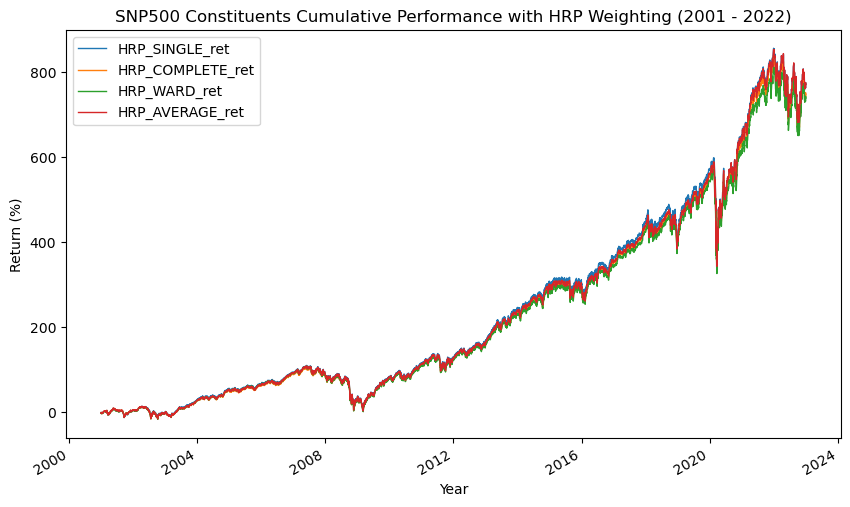

In [15]:
cum_ret_df.plot(figsize=(10,6), linewidth=1)
plt.title("SNP500 Constituents Cumulative Performance with HRP Weighting (2001 - 2022)")
plt.xlabel("Year")
plt.ylabel("Return (%)")
plt.show()

## Summarising HRP portfolio performance statistic across 2001 - 2022 period

In [17]:
summary_df = portfolio_summary.compute_portfolio_summary(ret_df=hrp_ret_df)
summary_df

,CUM_RET (%),CAGR (%),MAR (%),ANN_VOL (%),SHARPE,TSTAT,MAX_DD (%)
HRP_SINGLE_ret,771.68,10.34,11.55,17.77,0.72,3.37,-50.55
HRP_COMPLETE_ret,747.35,10.20,11.43,17.69,0.71,3.32,-50.53
HRP_WARD_ret,739.37,10.15,11.37,17.72,0.71,3.32,-51.56
HRP_AVERAGE_ret,771.64,10.34,11.57,17.75,0.72,3.36,-50.84


## Alternative portfolio construction techniques 
    1. Market Weight
    2. Equal Weight
    3. Risk Parity

#### Construction SNP500 Portfolio with Risk parity weighting

In [18]:
%%time
test_df_lst = list()

for year in range(2001, 2023):
    test_df = data_df[data_df["year"] == year].set_index("permno")
    stocks = test_df.index
    
    form_df = data_df[data_df["year"] == (year - 1)]
    form_df = form_df[form_df["permno"].isin(stocks)]
    
    weights_list = list()
    rp_weight_df = allocation.compute_rp_weights(df=form_df).to_frame()
    
    test_df = rp_weight_df.join(test_df)

    test_df["RP_ret"] = test_df["ret"] * test_df["RP_wgt"]
    test_df_lst.append(test_df)

CPU times: user 6.15 s, sys: 5 s, total: 11.1 s
Wall time: 2.74 s


In [19]:
rp_ret_df = pd.concat(test_df_lst, ignore_index=True, axis=0)

rp_ret_df = rp_ret_df.groupby("date")["RP_ret"].sum().to_frame()
rp_ret_df

,RP_ret
date,
2001-01-02,-0.024337
2001-01-03,0.030016
2001-01-04,-0.011468
2001-01-05,-0.015479
2001-01-08,0.002536
...,...
2022-12-23,0.006510
2022-12-27,0.001231
2022-12-28,-0.012585


#### Creating one daily timeseries df with Base case weighting, RP weighting and HRP weighting

In [20]:
final_ret_df = (base_ret_df.join(rp_ret_df)).join(hrp_ret_df)
final_ret_df.head()

,MKT_ret,EQ_ret,RP_ret,HRP_SINGLE_ret,HRP_COMPLETE_ret,HRP_WARD_ret,HRP_AVERAGE_ret
date,,,,,,,
2001-01-02,-0.028877,-0.028219,-0.024337,-0.022220,-0.021091,-0.021489,-0.022768
2001-01-03,0.055665,0.046295,0.030016,0.016905,0.011206,0.011315,0.018421
2001-01-04,-0.012854,-0.009114,-0.011468,-0.016400,-0.019365,-0.020613,-0.017008
2001-01-05,-0.025212,-0.020683,-0.015479,-0.009367,-0.007130,-0.006019,-0.010661
2001-01-08,-0.001344,0.002724,0.002536,0.003015,0.004551,0.004987,0.004044


#### Calculating Cumulative returns

In [21]:
cum_final_ret_df = ((1 + final_ret_df).cumprod() - 1) * 100
cum_final_ret_df

,MKT_ret,EQ_ret,RP_ret,HRP_SINGLE_ret,HRP_COMPLETE_ret,HRP_WARD_ret,HRP_AVERAGE_ret
date,,,,,,,
2001-01-02,-2.887738,-2.821934,-2.433719,-2.222036,-2.109071,-2.148851,-2.276841
2001-01-03,2.517980,1.676893,0.494876,-0.569098,-1.012113,-1.041645,-0.476660
2001-01-04,1.200163,0.750259,-0.657582,-2.199741,-2.929053,-3.081428,-2.169355
2001-01-05,-1.351296,-1.333511,-2.195287,-3.115874,-3.621168,-3.664775,-3.212369
2001-01-08,-1.483894,-1.064699,-1.947243,-2.823791,-3.182500,-3.184390,-2.820920
...,...,...,...,...,...,...,...
2022-12-23,431.607867,840.348309,807.498081,771.618369,748.091552,740.187042,772.147605
2022-12-27,427.671833,840.423787,808.614880,773.343287,749.050006,741.711957,773.416880
2022-12-28,421.626720,827.620093,797.179852,763.165312,739.284545,731.878001,763.271340


#### Plotting Cumulative Returns of all weighting methods

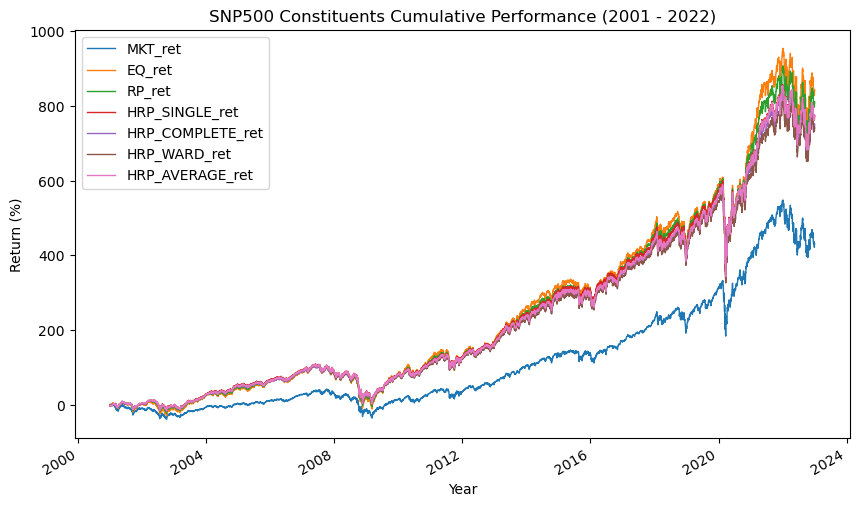

In [22]:
cum_final_ret_df.plot(figsize=(10,6), linewidth=1)

plt.title("SNP500 Constituents Cumulative Performance (2001 - 2022)")
plt.xlabel("Year")
plt.ylabel("Return (%)")
plt.show()

#### Deriving summary statistics to compare all cases

In [23]:
summary = (portfolio_summary.compute_portfolio_summary(final_ret_df))
summary

,CUM_RET (%),CAGR (%),MAR (%),ANN_VOL (%),SHARPE,TSTAT,MAX_DD (%)
MKT_ret,431.31,7.89,9.48,20.45,0.52,2.45,-54.28
EQ_ret,840.35,10.72,12.55,21.48,0.63,2.95,-57.19
RP_ret,807.55,10.55,12.03,19.79,0.67,3.16,-54.13
HRP_SINGLE_ret,771.68,10.34,11.55,17.77,0.72,3.37,-50.55
HRP_COMPLETE_ret,747.35,10.20,11.43,17.69,0.71,3.32,-50.53
HRP_WARD_ret,739.37,10.15,11.37,17.72,0.71,3.32,-51.56
HRP_AVERAGE_ret,771.64,10.34,11.57,17.75,0.72,3.36,-50.84


In [86]:
f = form_df[form_df.permno.isin(form_df.permno.unique()[:6])]
x = hrp_utils.create_correlation_matrix(f)
y = hrp_utils.create_correlation_matrix(f, covariance=True)

CPU times: user 100 ms, sys: 15.3 ms, total: 115 ms
Wall time: 61 ms


<AxesSubplot:xlabel='permno', ylabel='permno'>

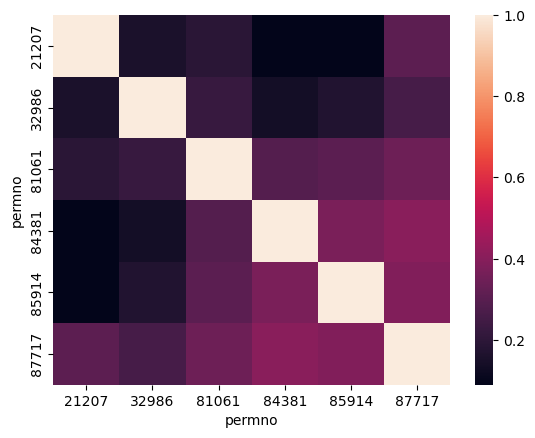

In [87]:
%%time
sns.heatmap(x)

In [88]:
import hrp

a = hrp.get_linkage(x, "single", "euclidean")
b = hrp.perform_quasi_diagonalization(a)

In [89]:
c = x.iloc[b, b]

<AxesSubplot:xlabel='permno', ylabel='permno'>

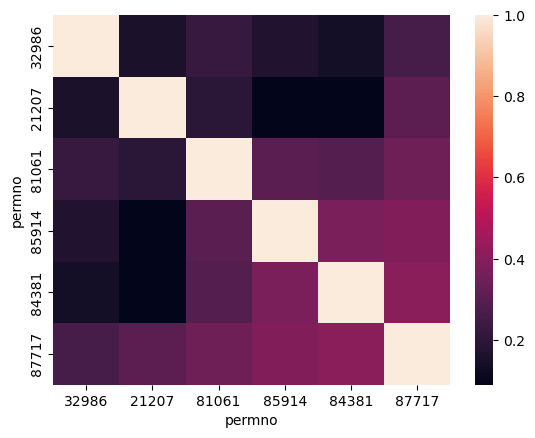

In [90]:
sns.heatmap(c)

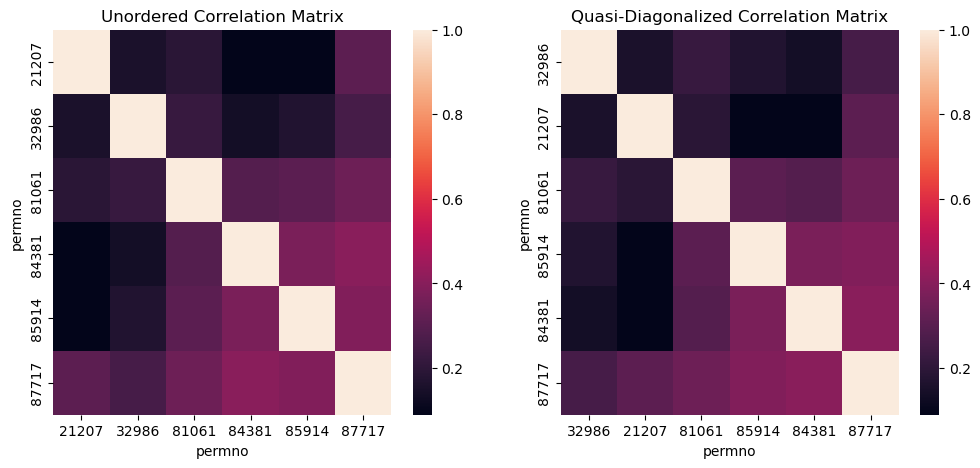

In [91]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

for i,j in enumerate([x,c]):
    ax = axs[i]
    sns.heatmap(j, ax=ax)
axs[0].set_title("Unordered Correlation Matrix")
axs[1].set_title("Quasi-Diagonalized Correlation Matrix")
plt.show()

In [92]:
from scipy.cluster.hierarchy import dendrogram

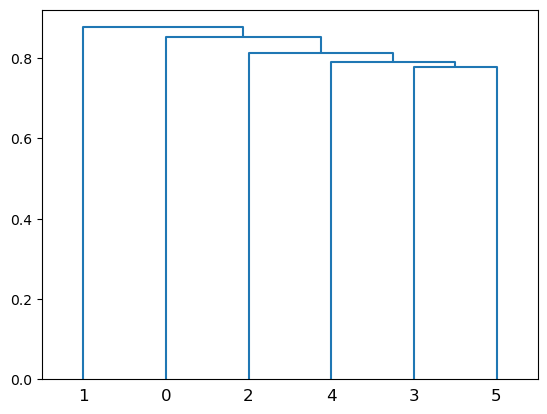

In [93]:
dendrogram(a)

plt.show()